# Location-based Feature Engineering for Listings 

This notebook utilises the coordinates to call a variety of APIs to create new features for each listing, providing an indication of the kinds of amenities, services and points of interest in the vicinity of the property. 

In [78]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import sys
from pathlib import Path
from shapely.geometry import Point
import numpy as np
from shapely import wkt


# Add project root to Python path
current_dir = Path().resolve()
if current_dir.name == 'notebooks':
    project_root = current_dir.parent
elif current_dir.name == 'project2':
    project_root = current_dir
else:
    # If we're in the parent directory, look for project2
    project_root = current_dir / 'project2'

sys.path.insert(0, str(project_root))
print(f"Project root: {project_root}")

from utils.preprocess import PreprocessUtils

# Initialize the preprocessor and geo utils
preprocessor = PreprocessUtils()

pd.set_option("display.max_rows", None)  # Show all rows, default is 10
pd.set_option("display.max_columns", None)  # Show all columns, default is 20

Project root: /Users/jackshee/University/MAST30034 Applied Data Science/project2


## 1. Set up API

Note: in the interest of time, we ran the sampled version instead. 

In [ ]:
# Read in cleaned_listings and cleaned_listings_sampled
df = pd.read_csv('../data/processed/domain/cleaned_listings.csv')

# Uncomment below and run only for sampled subset if time constrained
# df_sampled = pd.read_csv('../data/processed/domain/cleaned_listings_sampled.csv')

In [ ]:
batch_size = 500

# Set up the directories required from scripts to read from to call APIs 
for output_dir in ["../data/raw/missing_isochrones/driving", "../data/raw/missing_isochrones/walking", "../data/raw/missing_poi", "../data/raw/missing_routes"]:
    preprocessor.split_into_batches(df[['property_id', 'coordinates']], batch_size, output_dir)

# for output_dir in ["../data/raw/missing_isochrones_sampled/driving", "../data/raw/missing_isochrones_sampled/walking", "../data/raw/missing_poi_sampled", "../data/raw/missing_routes_sampled"]:
#     preprocessor.split_into_batches(df_sampled[['property_id', 'coordinates']], batch_size, output_dir)


### Optional Section 

Since we already made many API calls for the sampled dataset, we have stored results, we will merge these results to `df` and just get the remaining properties that need API fetches to create features on the full dataset. In the usual case, we would just run the pipeline directly on the full dataset so this section could be skipped.

In [ ]:
df_cleaned = pd.read_csv("../data/curated/rent_features/cleaned_listings_sampled.csv")

df_cleaned.info()

In [ ]:
driving_isochrone_features = ['driving_5min', 'driving_10min', 'driving_15min']
current_driving = df_cleaned[['property_id'] + driving_isochrone_features]
walking_isochrone_features = ['walking_5min', 'walking_10min', 'walking_15min']
current_walking = df_cleaned[['property_id'] + walking_isochrone_features]

In [ ]:
ptv_routes_features = ['closest_ptv_station_id', 'min_route_dist_m', 'min_route_dur_s']
current_routes = df_cleaned[['property_id'] + ptv_routes_features]

In [ ]:
current_poi = preprocessor.merge_batches("../data/processed/poi_features")
current_poi = pd.concat([current_poi, preprocessor.merge_batches("../data/processed/poi_features_wayback/")])
current_poi.info()

In [ ]:
current_poi['PropertyID'] = current_poi['PropertyID'].astype('Int64')
# rename 'PropertyID' to "property_id"
current_poi = current_poi.rename(columns={'PropertyID': 'property_id'})

current_poi.head()


In [ ]:
poi_features = current_poi.columns[1:]
poi_features

In [ ]:
# merge current_driving, current_walking, current_routes, current_poi to df on property_id
df = df.merge(current_driving, on='property_id', how='left')
df = df.merge(current_walking, on='property_id', how='left')
df = df.merge(current_routes, on='property_id', how='left')
df = df.merge(current_poi, on='property_id', how='left')

print(f"DataFrame shape after merging: {df.shape}")
print(f"Columns added: {len(current_driving.columns) + len(current_walking.columns) + len(current_routes.columns) + len(current_poi.columns) - 4}")  # -4 for property_id duplicates


In [ ]:
# sort by year, quarter and drop property_id duplicates keeping first
df = df.sort_values(['year', 'quarter'])
df = df.drop_duplicates(subset=['property_id'], keep='first')

print(f"DataFrame shape after deduplication: {df.shape}")
print(f"Records removed: {len(df_cleaned) - len(df)}")


In [ ]:
# Check which rows have null values in any of the PTV routes features
null_routes_mask = df[ptv_routes_features].isnull().any(axis=1)

# Get property_id and coordinates for rows with null PTV routes features
missing_routes_data = df[null_routes_mask][['property_id', 'coordinates']].copy()

print(f"Total rows in df: {len(df)}")
print(f"Rows with missing PTV routes data: {len(missing_routes_data)}")
print(f"Missing routes data shape: {missing_routes_data.shape}")

# Show first few rows
print("\nFirst 5 rows with missing PTV routes data:")
print(missing_routes_data.head())

preprocessor.split_into_batches(missing_routes_data, 500, output_dir='../data/raw/missing_routes_remain')


In [ ]:
# Check which rows have null values in all of the POI features
null_poi_mask = df[poi_features].isnull().all(axis=1)

# Get property_id and coordinates for rows with null PTV routes features
missing_poi_data = df[null_poi_mask][['property_id', 'coordinates']].copy()

print(f"Total rows in df: {len(df)}")
print(f"Rows with missing POI data: {len(missing_poi_data)}")
print(f"Missing POI data shape: {missing_poi_data.shape}")

# Show first few rows
print("\nFirst 5 rows with missing POI data:")
print(missing_poi_data.head())

# Split into batches
preprocessor.split_into_batches(missing_poi_data, 500, output_dir='../data/raw/missing_poi_remain')

In [ ]:
# Check which rows have null values in all of the POI features
null_driving_mask = df[driving_isochrone_features].isnull().any(axis=1)

# Get property_id and coordinates for rows with null driving isochrone features
missing_driving_data = df[null_driving_mask][['property_id', 'coordinates']].copy()

print(f"Total rows in df: {len(df)}")
print(f"Rows with missing driving isochrone data: {len(missing_driving_data)}")
print(f"Missing driving isochrone data shape: {missing_driving_data.shape}")

# Show first few rows
print("\nFirst 5 rows with missing driving isochrone data:")
print(missing_driving_data.head())

# Split into batches
preprocessor.split_into_batches(missing_driving_data, 500, output_dir='../data/raw/missing_isochrones_remain/driving')

In [ ]:
# Check which rows have null values in all of the POI features
null_walking_mask = df[walking_isochrone_features].isnull().any(axis=1)

# Get property_id and coordinates for rows with null walking isochrone features
missing_walking_data = df[null_walking_mask][['property_id', 'coordinates']].copy()

print(f"Total rows in df: {len(df)}")
print(f"Rows with missing walking isochrone data: {len(missing_walking_data)}")
print(f"Missing walking isochrone data shape: {missing_walking_data.shape}")

# Show first few rows
print("\nFirst 5 rows with missing walking isochrone data:")
print(missing_walking_data.head())

# Split into batches
preprocessor.split_into_batches(missing_walking_data, 500, output_dir='../data/raw/missing_isochrones_remain/walking')

## 2. Running the API scripts

In order to get the features, one must create API keys from https://account.heigit.org/login. For the full dataset that has 49 batches, one would need 49 keys to get all the data in 24hrs since the limiting API request is 500 and batches have been split into 500. Alternatively, 25 keys would enable the fetching of all the features over two days provided the scripts are run in separate terminals concurrently. 

To get the minimum distance and duration to the closest PTV station via roads network (driving), we run the `./run_routes.sh` shell script command from the terminal in the project root directory. It may be required enable run permissions `chmod +x run_routes.sh`. 

Likewise, to get the counts and minimum distance to various kinds of amenities (points of interest), run `./run_all_poi_batches.sh`. 

For isochrones (both driving and walking profile), run `./run_isochrones_batch_driving.sh` and run `./run_isochrones_batch_walking.sh`. This will return a POLYGON object that describes the reachable area within 5, 10 or 15mins of either driving or walking starting from an individual property. 

All fetched data are saved as `.csv` files with `property_id` and features in `data/processed` and are then further merged to `cleaned_listings.csv` on `property_id`. 

- `run_routes.sh` saves results into `data/processed/routes_ptv`
- `run_isochrones_driving.sh` and `run_isochrones_walking.sh` saves results into `data/processed/isochrones_driving` and `data/processed/isochrones_walking` respectively. 

## Merging results from separate API calls and Imputing

### Load in datasets for merging

In [65]:
routes_ptv = preprocessor.merge_batches("../data/processed/routes_ptv", verbose=False)
# drop coordinates column from routes_ptv
routes_ptv = routes_ptv.drop(columns=["coordinates"])
routes_ptv.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26319 entries, 0 to 26318
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   property_id       26319 non-null  int64  
 1   stationid         24082 non-null  object 
 2   min_route_dist_m  24082 non-null  float64
 3   min_route_dur_s   24082 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 822.6+ KB


In [66]:
poi_features = preprocessor.merge_batches("../data/processed/poi_features", verbose=False)

# print number of columns before dropping
print(f"Number of columns before dropping: {len(poi_features.columns)}")

# drop columns with greater than 50% nulls
poi_features = poi_features.dropna(axis=1, thresh=0.5*len(poi_features))

# print number of columns after dropping
print(f"Number of columns after dropping: {len(poi_features.columns)}")

# get number of nulls per column
poi_features.isnull().sum()


Number of columns before dropping: 131
Number of columns after dropping: 41


property_id                      0
count_childcare               7984
count_community_centre        5595
count_fast_food               1961
count_fire_station            8744
count_pharmacy                3780
min_dist_childcare            7984
min_dist_community_centre     5595
min_dist_fast_food            1961
min_dist_fire_station         8744
min_dist_pharmacy             3780
count_fuel                    1770
count_kindergarten            4057
count_parking_space           6550
min_dist_fuel                 1770
min_dist_kindergarten         4057
min_dist_parking_space        6550
count_cafe                    2500
count_charging_station        7681
count_clinic                  5769
min_dist_cafe                 2500
min_dist_charging_station     7681
min_dist_clinic               5769
count_police                 10332
min_dist_police              10332
count_bank                    6973
min_dist_bank                 6973
count_atm                     9295
count_library       

In [67]:
driving_isochrones = preprocessor.merge_batches("../data/processed/isochrones_driving", verbose=False)
walking_isochrones = preprocessor.merge_batches("../data/processed/isochrones_walking", verbose=False)

# drop coordinates column from driving_isochrones and walking_isochrones
driving_isochrones = driving_isochrones.drop(columns=["coordinates"])
walking_isochrones = walking_isochrones.drop(columns=["coordinates"])

# rename 5min, 10min, 15min to driving_5min, driving_10min, driving_15min
driving_isochrones.rename(columns={"5min": "driving_5min", "10min": "driving_10min", "15min": "driving_15min"}, inplace=True)
walking_isochrones.rename(columns={"5min": "walking_5min", "10min": "walking_10min", "15min": "walking_15min"}, inplace=True)


In [68]:
# read in cleaned_listings
cleaned_listings = pd.read_csv('../data/processed/domain/cleaned_listings.csv')

# Convert string coordinates to actual geometry objects
cleaned_listings["coordinates"] = cleaned_listings["coordinates"].apply(wkt.loads)

# Convert to GeoDataFrame
cleaned_listings = gpd.GeoDataFrame(cleaned_listings, geometry="coordinates")


### Merge OpenStreetMaps POI

In [69]:
# merge poi_features with cleaned_listings on property_id
cleaned_listings = cleaned_listings.merge(poi_features, on="property_id", how="left")
# show null value information
cleaned_listings.isnull().sum()

bedrooms                         0
property_id                      0
year                             0
coordinates                      0
source                           0
quarter                          0
bathrooms                        0
rental_price                     0
suburb                           0
longitude                        0
car_spaces                       0
latitude                         0
property_type                    0
count_childcare               7496
count_community_centre        5188
count_fast_food               1699
count_fire_station            8382
count_pharmacy                3483
min_dist_childcare            7496
min_dist_community_centre     5188
min_dist_fast_food            1699
min_dist_fire_station         8382
min_dist_pharmacy             3483
count_fuel                    1531
count_kindergarten            3725
count_parking_space           6112
min_dist_fuel                 1531
min_dist_kindergarten         3725
min_dist_parking_spa

In [70]:
# get the column names of cleaned_listings with null values
columns_with_na = list(cleaned_listings.columns[cleaned_listings.isnull().any()])

# amongst the columns_with_na, pick the columns that start with count_
count_cols = [col for col in columns_with_na if col.startswith("count_")]

# fill these count_cols with 0 and rename the column name with _imputed
cleaned_listings[count_cols] = cleaned_listings[count_cols].fillna(0)
cleaned_listings = cleaned_listings.rename(columns={col: col+"_imputed" for col in count_cols})

# show null value information
cleaned_listings.isnull().sum()

bedrooms                              0
property_id                           0
year                                  0
coordinates                           0
source                                0
quarter                               0
bathrooms                             0
rental_price                          0
suburb                                0
longitude                             0
car_spaces                            0
latitude                              0
property_type                         0
count_childcare_imputed               0
count_community_centre_imputed        0
count_fast_food_imputed               0
count_fire_station_imputed            0
count_pharmacy_imputed                0
min_dist_childcare                 7496
min_dist_community_centre          5188
min_dist_fast_food                 1699
min_dist_fire_station              8382
min_dist_pharmacy                  3483
count_fuel_imputed                    0
count_kindergarten_imputed            0


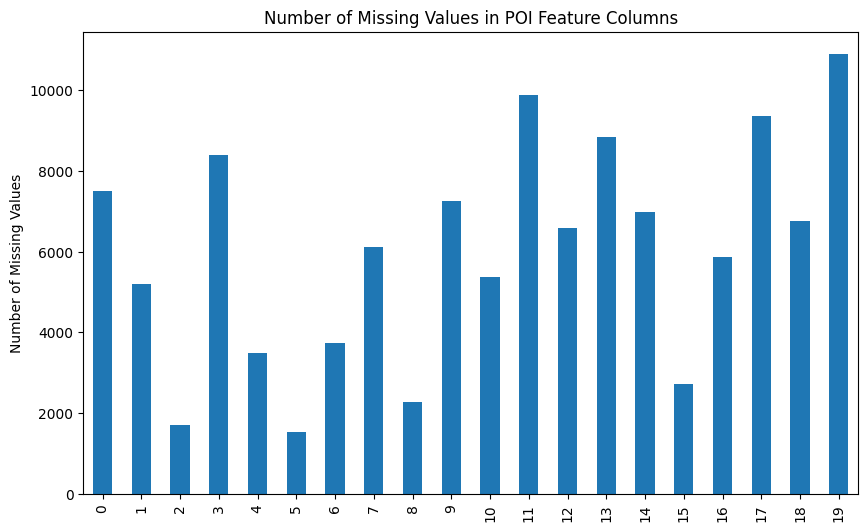

In [71]:
# update the column names of cleaned_listings with null values
columns_with_na = list(cleaned_listings.columns[cleaned_listings.isnull().any()])

# create a barchart of the number of missing values in each column of columns_with_na

# use matplotlib to create a barchart of the number of missing values in each column of columns_with_na
plt.figure(figsize=(10, 6))
cleaned_listings[columns_with_na].isnull().sum().plot(kind="bar")

# use numbers for the xticks labels
plt.xticks(range(len(columns_with_na)), range(len(columns_with_na)))
# rotate the xticks labels by 90 degrees
plt.xticks(rotation=90)
# set the y-axis label to "Number of Missing Values"
plt.ylabel("Number of Missing Values")
plt.title("Number of Missing Values in POI Feature Columns")

plt.show()

In [72]:
for col in columns_with_na:
    cleaned_listings[col+"_imputed"] = preprocessor.impute_by_nearest_point(cleaned_listings, col)

# Verify that all null values have been imputed
print("\nNull values remaining:")
print(cleaned_listings[columns_with_na].isnull().sum())


Imputing null values in 1 column(s): ['min_dist_childcare']
Total rows with null values to impute: 7496
Successfully imputed: 7496 rows, Could not impute (no data available): 0
Imputing null values in 1 column(s): ['min_dist_community_centre']
Total rows with null values to impute: 5188
Successfully imputed: 5188 rows, Could not impute (no data available): 0
Imputing null values in 1 column(s): ['min_dist_fast_food']
Total rows with null values to impute: 1699
Successfully imputed: 1699 rows, Could not impute (no data available): 0
Imputing null values in 1 column(s): ['min_dist_fire_station']
Total rows with null values to impute: 8382
Successfully imputed: 8382 rows, Could not impute (no data available): 0
Imputing null values in 1 column(s): ['min_dist_pharmacy']
Total rows with null values to impute: 3483
Successfully imputed: 3483 rows, Could not impute (no data available): 0
Imputing null values in 1 column(s): ['min_dist_fuel']
Total rows with null values to impute: 1531
Success

### Merge Routes PTV

In [73]:
# merge cleaned_listings with routes_ptv on property_id
cleaned_listings = cleaned_listings.merge(routes_ptv, on='property_id', how='left')

# rename stationid to closest_ptv_station_id
cleaned_listings = cleaned_listings.rename(columns={"stationid": "closest_ptv_station_id"})

# impute by nearest neighbour
cleaned_listings['closest_ptv_station_id_imputed'] = preprocessor.impute_by_nearest_point(cleaned_listings, 'closest_ptv_station_id')
cleaned_listings['min_route_dist_m_imputed'] = preprocessor.impute_by_nearest_point(cleaned_listings, 'min_route_dist_m')
cleaned_listings['min_route_dur_s_imputed'] = preprocessor.impute_by_nearest_point(cleaned_listings, 'min_route_dur_s')

# show null value information
cleaned_listings.isnull().sum()


Imputing null values in 1 column(s): ['closest_ptv_station_id']
Total rows with null values to impute: 776
Successfully imputed: 776 rows, Could not impute (no data available): 0
Imputing null values in 1 column(s): ['min_route_dist_m']
Total rows with null values to impute: 776
Successfully imputed: 776 rows, Could not impute (no data available): 0
Imputing null values in 1 column(s): ['min_route_dur_s']
Total rows with null values to impute: 776
Successfully imputed: 776 rows, Could not impute (no data available): 0


bedrooms                                 0
property_id                              0
year                                     0
coordinates                              0
source                                   0
quarter                                  0
bathrooms                                0
rental_price                             0
suburb                                   0
longitude                                0
car_spaces                               0
latitude                                 0
property_type                            0
count_childcare_imputed                  0
count_community_centre_imputed           0
count_fast_food_imputed                  0
count_fire_station_imputed               0
count_pharmacy_imputed                   0
min_dist_childcare                    7496
min_dist_community_centre             5188
min_dist_fast_food                    1699
min_dist_fire_station                 8382
min_dist_pharmacy                     3483
count_fuel_

### Merge Isochrones

In [74]:
# merge isochrones with cleaned_listings on property_id
cleaned_listings = cleaned_listings.merge(driving_isochrones, on="property_id", how="left")
cleaned_listings = cleaned_listings.merge(walking_isochrones, on="property_id", how="left")

# impute the isochrones with the nearest neighbour values
cleaned_listings[['driving_5min_imputed', 'driving_10min_imputed', 'driving_15min_imputed']] = preprocessor.impute_by_nearest_point(cleaned_listings, ['driving_5min', 'driving_10min', 'driving_15min'])
cleaned_listings[['walking_5min_imputed', 'walking_10min_imputed', 'walking_15min_imputed']] = preprocessor.impute_by_nearest_point(cleaned_listings, ['walking_5min', 'walking_10min', 'walking_15min'])

# show null value information
cleaned_listings.isnull().sum()

Imputing null values in 3 column(s): ['driving_5min', 'driving_10min', 'driving_15min']
Total rows with null values to impute: 9759
Successfully imputed: 9759 rows, Could not impute (no data available): 0
Imputing null values in 3 column(s): ['walking_5min', 'walking_10min', 'walking_15min']
Total rows with null values to impute: 9161
Successfully imputed: 9161 rows, Could not impute (no data available): 0


bedrooms                                 0
property_id                              0
year                                     0
coordinates                              0
source                                   0
quarter                                  0
bathrooms                                0
rental_price                             0
suburb                                   0
longitude                                0
car_spaces                               0
latitude                                 0
property_type                            0
count_childcare_imputed                  0
count_community_centre_imputed           0
count_fast_food_imputed                  0
count_fire_station_imputed               0
count_pharmacy_imputed                   0
min_dist_childcare                    7496
min_dist_community_centre             5188
min_dist_fast_food                    1699
min_dist_fire_station                 8382
min_dist_pharmacy                     3483
count_fuel_

## Creating School Score Features based on Isochrones

In [81]:
# Process school features using the refactored methods
print("Processing school features...")

# Convert cleaned_listings to GeoDataFrame for school processing
import geopandas as gpd
from shapely import wkt

# Convert WKT back to geometry if needed
if 'coordinates_wkt' in cleaned_listings.columns:
    cleaned_listings['coordinates'] = cleaned_listings['coordinates_wkt'].apply(wkt.loads)
    cleaned_listings = cleaned_listings.drop(columns=['coordinates_wkt'])

# Convert to GeoDataFrame
listings_gdf = gpd.GeoDataFrame(cleaned_listings, geometry='coordinates')
listings_gdf = listings_gdf.set_crs("EPSG:4326", inplace=False)

# Add listing_point column for school analysis
from shapely import ops
def swap_axes(geom):
    return ops.transform(lambda x, y, z=None: (y, x), geom)

listings_gdf["listing_point"] = listings_gdf["coordinates"].apply(swap_axes)
listings_gdf = listings_gdf.set_geometry("listing_point")

# Process school features using the complete workflow
cleaned_listings_with_schools = preprocessor.process_school_features_workflow(listings_gdf)

# Convert back to regular DataFrame for further processing
# Check which columns exist before dropping them
columns_to_drop = []
if 'geometry' in cleaned_listings_with_schools.columns:
    columns_to_drop.append('geometry')
if 'listing_point' in cleaned_listings_with_schools.columns:
    columns_to_drop.append('listing_point')

if columns_to_drop:
    cleaned_listings = cleaned_listings_with_schools.drop(columns=columns_to_drop)
else:
    cleaned_listings = cleaned_listings_with_schools

print("School features processing completed!")
print(f"New columns added: {[col for col in cleaned_listings.columns if 'school' in col.lower() or 'best_' in col.lower()]}")


Processing school features...
=== PROCESSING SCHOOL FEATURES ===
Step 1: Processing school data...
Loading and standardizing all school datasets...

Processing school_locations_2023.csv (year: 2023)
  Loaded 2302 schools
  Standardized to 25 columns

Processing school_locations_2025.csv (year: 2025)
  Loaded 2301 schools
  Standardized to 25 columns

Processing school_locations_2024.csv (year: 2024)
  Loaded 2294 schools
  Standardized to 25 columns

Combining 3 datasets...
Combined dataset shape: (6897, 25)
Total schools: 6897

Establishment year distribution:
establishment_year
2023    2302
2024    2294
2025    2301
Name: count, dtype: int64
Dropping 4534 duplicate schools based on fuzzy name and coordinates match.
Dataset shape after removing duplicates: (2363, 8)
Step 2: Adding school rankings...
Step 3: Calculating school goodness scores...
Step 4: Finding best schools per isochrone...
Step 5: Imputing missing school features...
Step 6: Finalizing school features...
School feature

/Users/jackshee/University/MAST30034 Applied Data Science/project2/utils/preprocess.py:2462: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/Users/jackshee/University/MAST30034 Applied Data Science/project2/utils/preprocess.py:2468: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


In [82]:
# Display summary of school features
school_columns = [col for col in cleaned_listings.columns if 'school' in col.lower() or 'best_' in col.lower()]
print(f"Total school-related columns: {len(school_columns)}")
print("\nSchool feature columns:")
for col in sorted(school_columns):
    print(f"  - {col}")

# Show sample of school features
print(f"\nSample of school features (first 5 rows):")
print(cleaned_listings[school_columns].head())

# Show missing values in school features
print(f"\nMissing values in school features:")
missing_school = cleaned_listings[school_columns].isnull().sum()
print(missing_school[missing_school > 0])


Total school-related columns: 30

School feature columns:
  - best_dist_km_driving_10min
  - best_dist_km_driving_15min
  - best_dist_km_driving_5min
  - best_dist_km_walking_10min
  - best_dist_km_walking_15min
  - best_dist_km_walking_5min
  - best_school_coord_driving_10min
  - best_school_coord_driving_15min
  - best_school_coord_driving_5min
  - best_school_coord_walking_10min
  - best_school_coord_walking_15min
  - best_school_coord_walking_5min
  - best_school_name_driving_10min
  - best_school_name_driving_15min
  - best_school_name_driving_5min
  - best_school_name_walking_10min
  - best_school_name_walking_15min
  - best_school_name_walking_5min
  - best_score_driving_10min
  - best_score_driving_15min
  - best_score_driving_5min
  - best_score_walking_10min
  - best_score_walking_15min
  - best_score_walking_5min
  - n_schools_driving_10min
  - n_schools_driving_15min
  - n_schools_driving_5min
  - n_schools_walking_10min
  - n_schools_walking_15min
  - n_schools_walking_5mi

In [83]:
cleaned_listings.isnull().sum()

bedrooms                                 0
property_id                              0
year                                     0
coordinates                              0
source                                   0
quarter                                  0
bathrooms                                0
rental_price                             0
suburb                                   0
longitude                                0
car_spaces                               0
latitude                                 0
property_type                            0
count_childcare_imputed                  0
count_community_centre_imputed           0
count_fast_food_imputed                  0
count_fire_station_imputed               0
count_pharmacy_imputed                   0
min_dist_childcare                    7496
min_dist_community_centre             5188
min_dist_fast_food                    1699
min_dist_fire_station                 8382
min_dist_pharmacy                     3483
count_fuel_

In [85]:
# Save as cleaned_listings as Parquet with Spark (ensuring files < 50MB)
from pyspark.sql import SparkSession
import os
from shapely import wkt

# Create a spark session
spark = (
    SparkSession.builder.appName("MAST30034 Feature Engineering")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "6g")
    .getOrCreate()
)

output_path = "../data/curated/rent_features/cleaned_listings_parquet"

# Create output directory if it doesn't exist
os.makedirs(os.path.dirname(output_path), exist_ok=True)

# Prepare the DataFrame for Spark by converting geometry objects to WKT strings
cleaned_listings_for_spark = cleaned_listings.copy()

# Convert geometry objects to WKT strings for Spark compatibility
if 'coordinates' in cleaned_listings_for_spark.columns:
    cleaned_listings_for_spark['coordinates_wkt'] = cleaned_listings_for_spark['coordinates'].apply(
        lambda x: x.wkt if hasattr(x, 'wkt') else str(x) if x is not None else None
    )
    # Drop the original coordinates column
    cleaned_listings_for_spark = cleaned_listings_for_spark.drop(columns=['coordinates'])

# Convert any other geometry columns to WKT strings
geometry_columns = [col for col in cleaned_listings_for_spark.columns 
                   if cleaned_listings_for_spark[col].dtype == 'object' and 
                   any(cleaned_listings_for_spark[col].dropna().apply(
                       lambda x: hasattr(x, 'wkt') if x is not None else False
                   ))]

for col in geometry_columns:
    cleaned_listings_for_spark[f"{col}_wkt"] = cleaned_listings_for_spark[col].apply(
        lambda x: x.wkt if hasattr(x, 'wkt') else str(x) if x is not None else None
    )
    cleaned_listings_for_spark = cleaned_listings_for_spark.drop(columns=[col])

# Convert pandas DataFrame to Spark DataFrame
spark_df = spark.createDataFrame(cleaned_listings_for_spark)

# Save as Parquet with partitioning to ensure files < 50MB
# Using coalesce to control the number of output files
spark_df.coalesce(10).write.mode("overwrite").parquet(output_path)

print(f"Successfully saved cleaned_listings to {output_path}")
print(f"Dataset shape: {cleaned_listings_for_spark.shape}")
print(f"Number of partitions: 10")
print(f"Geometry columns converted to WKT: {geometry_columns}")

# Stop the Spark session
spark.stop()


25/10/22 13:51:32 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
25/10/22 13:51:35 WARN TaskSetManager: Stage 0 contains a task of very large size (95650 KiB). The maximum recommended task size is 1000 KiB.


Successfully saved cleaned_listings to ../data/curated/rent_features/cleaned_listings_parquet
Dataset shape: (24027, 133)
Number of partitions: 10
Geometry columns converted to WKT: ['driving_5min', 'driving_10min', 'driving_15min', 'walking_5min', 'walking_10min', 'walking_15min', 'driving_5min_imputed', 'driving_10min_imputed', 'driving_15min_imputed', 'walking_5min_imputed', 'walking_10min_imputed', 'walking_15min_imputed', 'geom_driving_5min', 'geom_driving_10min', 'geom_driving_15min', 'geom_walking_5min', 'geom_walking_10min', 'geom_walking_15min', 'geom_driving_5min_imputed', 'geom_driving_10min_imputed', 'geom_driving_15min_imputed', 'geom_walking_5min_imputed', 'geom_walking_10min_imputed', 'geom_walking_15min_imputed', 'best_school_coord_driving_5min', 'best_school_coord_driving_10min', 'best_school_coord_driving_15min', 'best_school_coord_walking_5min', 'best_school_coord_walking_10min', 'best_school_coord_walking_15min']
